# Resnet18 usando PyTorch Lightning
## Trabajo

- Basado en el notebook de una CNN compleja pre-entrenada o no, cambiar el modelo convolucional a otro definido en pytorch y cambiar la base de datos (preferiblemente Fashion MNIST).

- Implementar al menos dos técnicas de aumento de datos y adaptar early stopping.



## Instalar e importar bibliotecas


In [ ]:
#!pip install roboflow

#from roboflow import Roboflow
#rf = Roboflow(api_key="jRqv9XrIkkWue4CkQnGN")
#project = rf.workspace("yoloiguess").project("dog-emotions-5ty9e")
#version = project.version(3)
#dataset = version.download("multiclass")


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("devzohaib/dog-emotions-prediction")

print("Path to dataset files:", path)

100%|██████████| 379M/379M [00:14<00:00, 28.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/devzohaib/dog-emotions-prediction/versions/1


In [ ]:
!pip install lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import numpy as np
import os
%matplotlib inline
import matplotlib.pyplot as plt
import time
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
import torchmetrics

from collections import Counter
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split

from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import TQDMProgressBar, RichProgressBar


Path to dataset files: /root/.cache/kagglehub/datasets/devzohaib/dog-emotions-prediction/versions/1


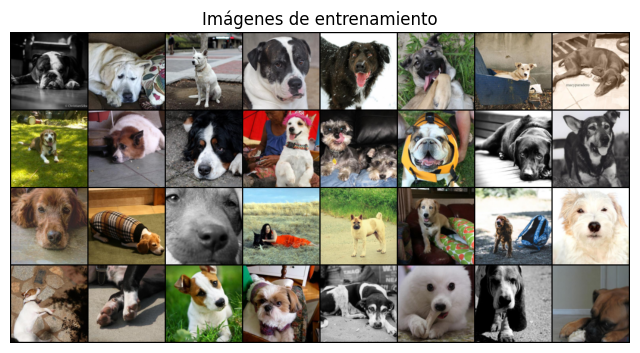

Dimensión de entrada: torch.Size([32, 3, 128, 128])
Etiquetas: ['sad', 'sad', 'sad', 'sad', 'happy', 'happy', 'relaxed', 'relaxed', 'happy', 'sad']


In [ ]:
import os
import kagglehub
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Descargar el dataset desde Kaggle
path = kagglehub.dataset_download("devzohaib/dog-emotions-prediction")
print("Path to dataset files:", path)

# Ruta ajustada al directorio de las imágenes
dataset_path = os.path.join(path, "images")

# Transformaciones para las imágenes
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Redimensionar imágenes a 128x128 píxeles
    transforms.ToTensor(),         # Convertir imágenes a tensores
    transforms.Normalize((0.5,), (0.5,))  # Normalizar valores de píxeles
])

# Verificar que la ruta existe
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"No se encontró la ruta: {dataset_path}")

# Cargar el dataset usando ImageFolder
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Dividir en dataset de entrenamiento y prueba
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Crear DataLoaders
BATCH_SIZE = 32
NUM_WORKERS = 2

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         num_workers=NUM_WORKERS,
                         shuffle=False)

# Visualización de imágenes de entrenamiento
for images, labels in train_loader:
    break

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Imágenes de entrenamiento")
plt.imshow(np.transpose(torchvision.utils.make_grid(
    images[:64],
    padding=2,
    normalize=True),
    (1, 2, 0)))
plt.show()

print("Dimensión de entrada:", images.shape)  # (batch_size, channels, W, H)
print("Etiquetas:", [dataset.classes[label] for label in labels[:10]])


In [ ]:
dataset.classes

['angry', 'happy', 'relaxed', 'sad']

## Definición de hiperparámetros de la red

In [ ]:
BATCH_SIZE = 16
NUM_EPOCHS = 60
LEARNING_RATE = 0.001
NUM_WORKERS = 4 # unidades de procesamiento o hilos
CLASES = 10

## Preparación de la base de datos: FASHION MNIST

### FASHION MNIST contiene 70k RGB imágenes de 28x28x1 pixeles distribuidas en 10 clases.

*   Grupo de entrenamiento: 60K imágenes
*   Grupo de evaluación: 10k imágenes

### Definición de FASHION MNIST DataModule para Lightning

In [ ]:
import os
import pytorch_lightning as pl
from torchvision import transforms, datasets
from torch.utils.data import random_split, DataLoader


class DogEmotionsDataModule(pl.LightningDataModule):
    def __init__(self, data_path="./"):
        super().__init__()
        self.data_path = data_path  # Ruta donde está el dataset

    def prepare_data(self):
        # Transformaciones para entrenamiento
        self.train_transform = transforms.Compose([
            transforms.Resize((224, 224)),  # Redimensionar imágenes para RESNET18
            transforms.RandomHorizontalFlip(p=0.5),  # Volteo horizontal con probabilidad 50%
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Ajustes aleatorios de color
            transforms.RandomRotation(degrees=15),  # Rotación aleatoria entre -15 y 15 grados
            transforms.ToTensor(),  # Convertir imagen en tensor
            transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalización basada en ImageNet
                                 std=[0.229, 0.224, 0.225]),
        ])

        # Transformaciones para prueba y validación
        self.test_transform = transforms.Compose([
            transforms.Resize((224, 224)),  # Redimensionar imágenes
            transforms.ToTensor(),  # Convertir imagen en tensor
            transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalización basada en ImageNet
                                 std=[0.229, 0.224, 0.225]),
        ])
        return

    def setup(self, stage=None):
        # Cargar dataset usando ImageFolder
        dataset = datasets.ImageFolder(
            root=self.data_path,
            transform=self.train_transform if stage == 'fit' else self.test_transform
        )

        # Dividir dataset en entrenamiento (80%), validación (10%) y prueba (10%)
        train_size = int(0.8 * len(dataset))
        val_size = int(0.1 * len(dataset))
        test_size = len(dataset) - train_size - val_size

        self.train, self.valid, self.test = random_split(dataset, [train_size, val_size, test_size])

        print("Muestras de entrenamiento:", len(self.train))
        print("Muestras de validación:", len(self.valid))
        print("Muestras de evaluación:", len(self.test))

    def train_dataloader(self):
        train_loader = DataLoader(
            dataset=self.train,
            batch_size=BATCH_SIZE,
            drop_last=True,
            shuffle=True,
            num_workers=NUM_WORKERS,
        )
        return train_loader

    def val_dataloader(self):
        valid_loader = DataLoader(
            dataset=self.valid,
            batch_size=BATCH_SIZE,
            drop_last=False,
            shuffle=False,
            num_workers=NUM_WORKERS,
        )
        return valid_loader

    def test_dataloader(self):
        test_loader = DataLoader(
            dataset=self.test,
            batch_size=BATCH_SIZE,
            drop_last=False,
            shuffle=False,
            num_workers=NUM_WORKERS,
        )
        return test_loader


In [ ]:
data_path = "/root/.cache/kagglehub/datasets/devzohaib/dog-emotions-prediction/versions/1/images"

data_module = DogEmotionsDataModule(data_path=data_path)
data_module.prepare_data()
data_module.setup(stage='fit')

train_loader = data_module.train_dataloader()
valid_loader = data_module.val_dataloader()
test_loader = data_module.test_dataloader()


Muestras de entrenamiento: 12736
Muestras de validación: 1592
Muestras de evaluación: 1593


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
print("Tamaño del conjunto de entrenamiento:", len(data_module.train))
print("Tamaño del conjunto de validación:", len(data_module.valid))
print("Tamaño del conjunto de prueba:", len(data_module.test))

Tamaño del conjunto de entrenamiento: 12736
Tamaño del conjunto de validación: 1592
Tamaño del conjunto de prueba: 1593


In [ ]:
# Inicialización de DataModule
torch.manual_seed(47)  # Fijar una semilla para reproducibilidad

# Especifica la ruta correcta al dataset de imágenes de emociones de perros
data_path = "/root/.cache/kagglehub/datasets/devzohaib/dog-emotions-prediction/versions/1/images"

# Inicializar el DataModule con la nueva clase
data_module = DogEmotionsDataModule(data_path=data_path)

# Preparar los datos (transformaciones y verificaciones)
data_module.prepare_data()

# Configurar el dataset para entrenamiento, validación y prueba
data_module.setup(stage='fit')

Muestras de entrenamiento: 12736
Muestras de validación: 1592
Muestras de evaluación: 1593


In [ ]:
# class FMNIST_DataModule(pl.LightningDataModule):
#     def __init__(self, data_path="./"):
#         super().__init__()
#         self.data_path = data_path # donde estará alojado el dataset

#     def prepare_data(self): # Método prepare_data es usado para pasos que van a ser ejecutados solo una vez, como descargar el dataset y definir las transformaciones

#         self.train_transform = transforms.Compose([
#             transforms.Resize((224, 224)), # RESNET18 trabaja sobre imagenes 224*224*3
#             transforms.Grayscale(num_output_channels=3), # RESNET18 trabaja sobre imagenes con 3 canales
#             transforms.RandomHorizontalFlip(p=0.5),  # Añade un 50% de probabilidad de voltear horizontalmente
#             transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Ajustes aleatorios de color
#             transforms.RandomRotation(degrees=15),  # Rotación aleatoria entre -15 y 15 grados
#             transforms.ToTensor(),  # Convierte la imagen en un tensor
#             transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalizar con la media y desviación estándar de ImageNet
#                          std=[0.229, 0.224, 0.225]),
#             ])

#         self.test_transform = torchvision.transforms.Compose([
#             transforms.Resize((224, 224)), # RESNET18 trabaja sobre imagenes 224*224*3
#             transforms.Grayscale(num_output_channels=3), # RESNET18 trabaja sobre imagenes con 3 canales
#             transforms.ToTensor(),  # Convierte la imagen en un tensor
#             transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalizar con la media y desviación estándar de ImageNet
#                          std=[0.229, 0.224, 0.225]),])
#         return

#     def setup(self, stage=None):   # cargamos el dataset
#         train = datasets.FashionMNIST(
#             root=self.data_path,
#             train=True,
#             transform=self.train_transform,
#             download=False,
#         )

#         self.test = datasets.FashionMNIST(
#             root=self.data_path,
#             train=False, # False para obtener el grupo de test
#             transform=self.test_transform,
#             download=False,
#         )

#         # Dividir el grupo de entrenamiento original en entrenamiento y validación

#         self.train, self.valid = random_split(train, lengths=[int(len(train)*0.9), int(len(train)*0.1)])

#         print("Muestras de entrenamiento:", len(self.train))
#         print("Muestras de validación:", len(self.valid))
#         print("Muestras de evaluación:", len(self.test))

#     def train_dataloader(self):
#         train_loader = DataLoader(
#             dataset=self.train,
#             batch_size=BATCH_SIZE,
#             drop_last=True,
#             shuffle=True,
#             num_workers=NUM_WORKERS,
#         )
#         return train_loader

#     def val_dataloader(self):
#         valid_loader = DataLoader(
#             dataset=self.valid,
#             batch_size=BATCH_SIZE,
#             drop_last=False,
#             shuffle=False,
#             num_workers=NUM_WORKERS,
#         )
#         return valid_loader

#     def test_dataloader(self):
#         test_loader = DataLoader(
#             dataset=self.test,
#             batch_size=BATCH_SIZE,
#             drop_last=False,
#             shuffle=False,
#             num_workers=NUM_WORKERS,
#         )
#         return test_loader

In [ ]:
# # Inicizalización de DataModule

# torch.manual_seed(47)  # especificamos un random seed para reproducibilidad de inicializaciones aleatorias
# data_module = FMNIST_DataModule(data_path='/home/smorillo/dataFMNIST')

## Importar la arquitectura resnet18

In [ ]:
pytorch_model = torch.hub.load('pytorch/vision:v0.11.0', 'mobilenet_v2', weights='MobileNet_V2_Weights.IMAGENET1K_V1')

Downloading: "https://github.com/pytorch/vision/zipball/v0.11.0" to /root/.cache/torch/hub/v0.11.0.zip
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 60.8MB/s]


Modificamos el numero de clases de salida en resnet18

In [ ]:
pytorch_model

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [ ]:
pytorch_model.classifier[1]

Linear(in_features=1280, out_features=1000, bias=True)

In [ ]:
# Sobre escribimos el clasificador de la red, el cual es la ultima capa [-1]
pytorch_model.classifier[1] = torch.nn.Linear(
    in_features=1280,  # Salida del último bloque convolucional de MobileNetV2
    out_features=4  # Número de clases en la salida
)

In [ ]:
# Arquitectura modifica a FASHION MNIST
pytorch_model

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

Seleccionamos el número de capas que van a re-entrenarse

In [ ]:
# Conocer numero de parámetros
for i, param in enumerate(pytorch_model.parameters()):
  i
print(i)


157


In [ ]:


#anda probando bloque por bloque
threshold = 130 # no se modifica el ~80% del número total de parámetros de RESNET18
for i, param in enumerate(pytorch_model.parameters()):
    if i < threshold:
        param.requires_grad = False
    elif i >= threshold:
        param.requires_grad = True

In [ ]:
20/150

0.13333333333333333

## Definición del Módulo Lightning

In [ ]:
# import torch
# import torch.nn.functional as F
# import pytorch_lightning as pl
# import torchmetrics

# class Lightning_CNN(pl.LightningModule):
#     def __init__(self, model, learning_rate, num_classes):
#         super().__init__()

#         self.learning_rate = learning_rate
#         self.model = model
#         self.num_classes = num_classes

#         # Guardar hiperparámetros (sin incluir el modelo)
#         self.save_hyperparameters(ignore=["model"])

#         # Definición de métricas para entrenamiento, validación y prueba
#         self.train_acc = torchmetrics.Accuracy(num_classes=self.num_classes, task='multiclass')
#         self.valid_acc = torchmetrics.Accuracy(num_classes=self.num_classes, task='multiclass')
#         self.test_acc = torchmetrics.Accuracy(num_classes=self.num_classes, task='multiclass')

#     def forward(self, x):
#         """Definición del paso forward (necesario para .predict())."""
#         return self.model(x)

#     def _shared_step(self, batch):
#         """Paso compartido para entrenamiento, validación y prueba."""
#         features, true_labels = batch
#         logits = self(features)  # Paso forward con el modelo
#         loss = F.cross_entropy(logits, true_labels)  # Calcula la pérdida (cross entropy)
#         probs = F.softmax(logits, dim=1)  # Convierte los logits en probabilidades
#         predicted_labels = torch.argmax(probs, dim=1)  # Predicción de etiquetas

#         return loss, true_labels, predicted_labels

#     def training_step(self, batch, batch_idx):
#         """Paso de entrenamiento."""
#         loss, true_labels, predicted_labels = self._shared_step(batch)
#         self.log("train_loss", loss)

#         # Evaluar la precisión en modo eval para evitar efectos de Dropout o BatchNorm
#         self.model.eval()
#         with torch.no_grad():
#             _, true_labels, predicted_labels = self._shared_step(batch)
#         self.train_acc(predicted_labels, true_labels)
#         self.log("train_acc", self.train_acc, on_epoch=True, on_step=False)
#         self.model.train()

#         return loss  # Devuelve la pérdida al optimizador

#     def validation_step(self, batch, batch_idx):
#         """Paso de validación."""
#         loss, true_labels, predicted_labels = self._shared_step(batch)
#         self.log("valid_loss", loss)
#         self.valid_acc(predicted_labels, true_labels)
#         self.log("valid_acc", self.valid_acc, on_epoch=True, on_step=False, prog_bar=True)

#     def test_step(self, batch, batch_idx):
#         """Paso de prueba."""
#         loss, true_labels, predicted_labels = self._shared_step(batch)
#         self.test_acc(predicted_labels, true_labels)
#         self.log("test_acc", self.test_acc, on_epoch=True, on_step=False)

#     def configure_optimizers(self):
#         """Definición del optimizador (Adam)."""
#         optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
#         return optimizer


In [ ]:
class Lightning_CNN(pl.LightningModule):
    def __init__(self, model, learning_rate, classes):
        super().__init__()

        self.learning_rate = learning_rate
        self.model = model
        self.classes = classes

        # Guardar hiperparametros en directorio de logs
        # Ignora los pesos del modelo
        self.save_hyperparameters(ignore=["model"])

        # Definición de métricas para cada grupo de datos
        self.train_acc = torchmetrics.Accuracy(num_classes = self.classes, task='multiclass')
        self.valid_acc = torchmetrics.Accuracy(num_classes = self.classes, task='multiclass')
        self.test_acc = torchmetrics.Accuracy(num_classes = self.classes, task='multiclass')

    # Defining the forward method is only necessary
    # if you want to use a Trainer's .predict() method (optional)
    def forward(self, x):
        return self.model(x)

    # Pasos del proceso forward comunes entre train, val, test
    def _shared_step(self, batch):
        features, true_labels = batch
        logits = self(features)
        loss = torch.nn.functional.cross_entropy(logits, true_labels) # cross entropy loss recibe logits y labels como entrada. No recibe probabilidades!
        probs = torch.nn.functional.softmax(logits, dim=1)
        predicted_labels = torch.argmax(probs, dim=1)

        return loss, true_labels, predicted_labels

    def training_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.log("train_loss", loss)

        # Do another forward pass in .eval() mode to compute accuracy
        # while accounting for Dropout, BatchNorm etc. behavior
        # during evaluation (inference)
        self.model.eval()
        with torch.no_grad():
            _, true_labels, predicted_labels = self._shared_step(batch)
        self.train_acc(predicted_labels, true_labels)
        self.log("train_acc", self.train_acc, on_epoch=True, on_step=False)
        self.model.train()

        return loss  # this is passed to the optimzer for training

    def validation_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.log("valid_loss", loss)
        self.valid_acc(predicted_labels, true_labels)
        self.log("valid_acc", self.valid_acc, on_epoch=True, on_step=False, prog_bar=True)

    def test_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.test_acc(predicted_labels, true_labels)
        self.log("test_acc", self.test_acc, on_epoch=True, on_step=False)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

## Entrenamiento del modelo

In [ ]:
# # Inicialización del modelo Lightning con los hiperparámetros y número de clases
# lightning_model = Lightning_CNN(
#     model=pytorch_model,
#     learning_rate=1e-3,  # Tasa de aprendizaje definida (puedes ajustarla)
#     num_classes=4  # Número de clases: angry, happy, relaxed, sad
# )

# # Callback para guardar el mejor modelo según la métrica de validación
# callback_check = ModelCheckpoint(
#     save_top_k=1,  # Guardar solo el mejor modelo
#     mode="max",  # Buscar el máximo valor (mejor accuracy)
#     monitor="valid_acc",  # Métrica monitoreada: precisión en validación
#     dirpath="./checkpoints",  # Directorio donde se guardarán los modelos
#     filename="best-model-{epoch:02d}-{valid_acc:.4f}"  # Nombre del archivo
# )

# # Barra de progreso con Rich
# callback_tqdm = RichProgressBar(leave=True)

# # Callback para detener el entrenamiento temprano si no hay mejoras
# early_stop_callback = EarlyStopping(
#     monitor="valid_acc",  # Métrica monitoreada
#     patience=10,  # Número de épocas sin mejora antes de detener
#     mode="max"  # Buscar el máximo valor (mejor accuracy)
# )

# # Logger para guardar información del entrenamiento en un CSV
# logger = CSVLogger(
#     save_dir="./logs/",  # Directorio donde se guardarán los logs
#     name="dog-emotions-resnet18",  # Nombre de la carpeta para este entrenamiento
#     flush_logs_every_n_steps=10  # Guardar los logs cada 10 pasos
# )


In [ ]:
# Inicialización del modulo lightning

lightning_model = Lightning_CNN(pytorch_model, learning_rate=LEARNING_RATE, classes=CLASES)

callback_check = ModelCheckpoint(save_top_k=1, mode="max", monitor="valid_acc") # guardamos el mejor modelo monitoreado en la acc de validación. Por qué no la de entrenamiento?

callback_tqdm = RichProgressBar(leave=True)

early_stop_callback = EarlyStopping( # se agrega un callback de earlystopping para asegurar que el modelo se detenga en un momento óptimo monitoreando la métrica de accuracy
    monitor="valid_acc",
    patience=10, # se establece una paciencia de 3 épocas
    mode="max"
)

logger = CSVLogger(save_dir="./logs/", name="dog-emotion")


In [ ]:
# from pytorch_lightning import Trainer

# trainer = Trainer(
#     max_epochs=20,  # Número máximo de épocas
#     callbacks=[callback_check, callback_tqdm, early_stop_callback],  # Callbacks
#     logger=logger,  # Logger para guardar logs en CSV
#     accelerator="gpu",  # Usa GPU si está disponible
#     devices=1 if torch.cuda.is_available() else None,  # Detecta automáticamente
#     log_every_n_steps=10,  # Registro cada 10 pasos
# )

# # Entrenamiento del modelo
# trainer.fit(lightning_model, data_module)


In [ ]:
#  Inicia entrenamiento

trainer = pl.Trainer(max_epochs= NUM_EPOCHS,
                    callbacks=[callback_check, callback_tqdm, early_stop_callback],
                    accelerator="auto",  # Uses GPUs or TPUs if available
                    devices="auto",  # Uses all available GPUs/TPUs if applicable
                    logger=logger,
                    log_every_n_steps=100)

start_time = time.time()
trainer.fit(model = lightning_model, datamodule = data_module)

runtime = (time.time() - start_time) / 60
print(f"Tiempo de entrenamiento en minutos: {runtime:.2f}")

Epoch 23/59 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 796/796 0:02:50 • 0:00:00 4.75it/s v_num: 0.000 valid_acc: 0.523

Tiempo de entrenamiento en minutos: 75.23


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Non-trainable params:

*   BatchNorm2d Running Statistics: running_mean and running_var in each batch normalization layer.

## Graficamos las curvas de aprendizaje del modelo

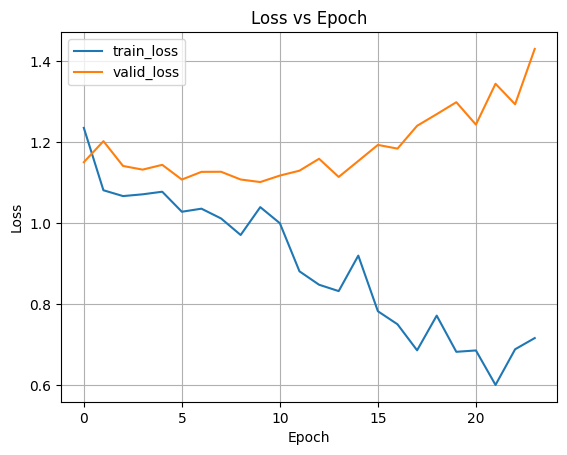

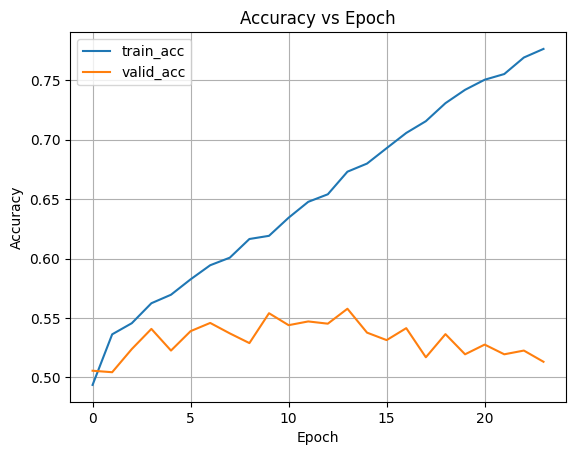

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Leer métricas del archivo CSV generado por el logger
metrics_path = f"{trainer.logger.log_dir}/metrics.csv"
metrics = pd.read_csv(metrics_path)

# Agregar métricas por época
aggreg_metrics = []
agg_col = "epoch"  # Agrupar por la columna de época
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())  # Calcular la media para todas las métricas por época
    agg[agg_col] = i
    aggreg_metrics.append(agg)

# Convertir a DataFrame para visualización
df_metrics = pd.DataFrame(aggreg_metrics)

# Graficar las pérdidas (loss) para entrenamiento y validación
df_metrics[["train_loss", "valid_loss"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="Loss", title="Loss vs Epoch"
)

# Graficar las precisiones (accuracy) para entrenamiento y validación
df_metrics[["train_acc", "valid_acc"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="Accuracy", title="Accuracy vs Epoch"
)

# Mostrar las gráficas
plt.show()


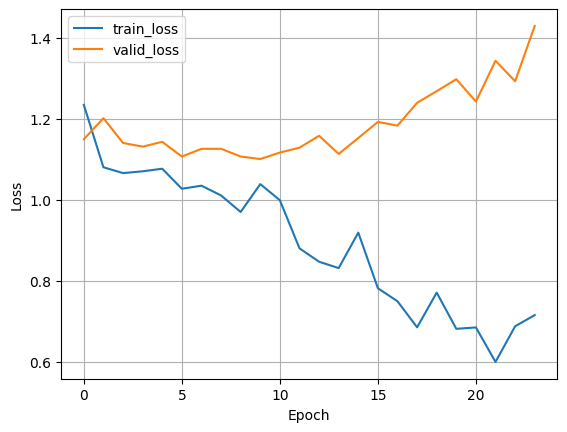

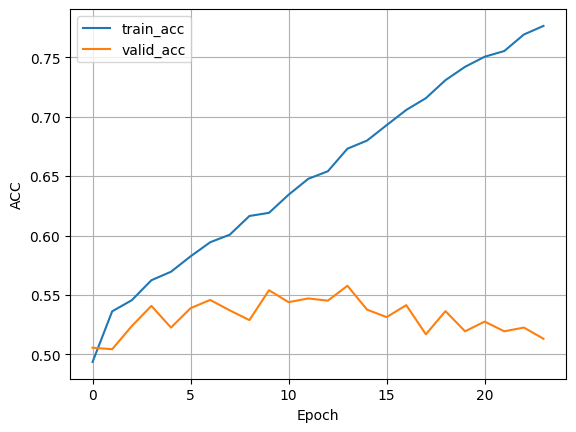

In [ ]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[["train_loss", "valid_loss"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="Loss"
)
df_metrics[["train_acc", "valid_acc"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="ACC"
)

plt.show()

## Evaluamos el mejor modelo en el grupo de test

In [ ]:
# Probar el modelo utilizando el mejor checkpoint guardado
trainer.test(
    model=lightning_model,
    datamodule=data_module,
    ckpt_path=callback_check.best_model_path  # Cargar el mejor modelo guardado automáticamente
)


Testing ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100/100 0:00:08 • 0:00:00 11.19it/s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.694915235042572     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.694915235042572}]

In [ ]:
print(f"Mejor modelo guardado en: {callback_check.best_model_path}")


Mejor modelo guardado en: ./logs/dog-emotion/version_0/checkpoints/epoch=13-step=11144.ckpt


In [ ]:
trainer.test(model = lightning_model, datamodule = data_module, ckpt_path = 'best') # cargamos el mejor checkpoint del modelo

Testing ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100/100 0:00:10 • 0:00:00 9.43it/s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6779661178588867     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.6779661178588867}]

In [ ]:
df_metrics

,epoch,step,train_acc,train_loss,valid_acc,valid_loss
0,0,487.0,0.493719,1.235187,0.505653,1.150350
1,1,1237.4,0.536275,1.081108,0.504397,1.202317
2,2,2036.6,0.545619,1.066713,0.523869,1.141087
3,3,2835.8,0.562422,1.071088,0.540829,1.132052
4,4,3635.0,0.569567,1.077491,0.522613,1.143889
5,5,4434.2,0.582522,1.028043,0.538945,1.107498
6,6,5233.4,0.594378,1.035610,0.545854,1.126538
7,7,6032.6,0.600738,1.011502,0.537060,1.126768
8,8,6831.8,0.616442,0.970666,0.528894,1.107667
9,9,7631.0,0.619111,1.039458,0.554020,1.101362


In [ ]:
import torch
import pandas as pd
import sqlite3

# Evaluar el modelo en el conjunto de prueba
trainer.test(model=lightning_model, datamodule=data_module, ckpt_path=callback_check.best_model_path)

# Obtener el dataloader de prueba
test_dataloader = data_module.test_dataloader()

# Listas para almacenar los resultados
predictions = []
labels = []

# Modo evaluación
lightning_model.eval()

# Deshabilitar el cálculo de gradientes para inferencia
with torch.no_grad():
    for batch in test_dataloader:
        inputs, targets = batch  # Obtener imágenes y etiquetas verdaderas

        outputs = lightning_model(inputs)  # Obtener predicciones del modelo

        _, predicted = torch.max(outputs, 1)  # Obtener la clase con mayor probabilidad

        predictions.extend(predicted.cpu().numpy())  # Guardar predicciones
        labels.extend(targets.cpu().numpy())  # Guardar etiquetas reales

# Crear un DataFrame con los resultados
df_results = pd.DataFrame({"Label": labels, "Prediction": predictions})



Testing ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100/100 0:00:09 • 0:00:00 10.51it/s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.700564980506897     │
└───────────────────────────┴───────────────────────────┘

In [ ]:
df_results

,Label,Prediction
0,1,1
1,2,3
2,0,0
3,2,2
4,3,3
...,...,...
1588,3,3
1589,0,0
1590,2,2
1591,3,2


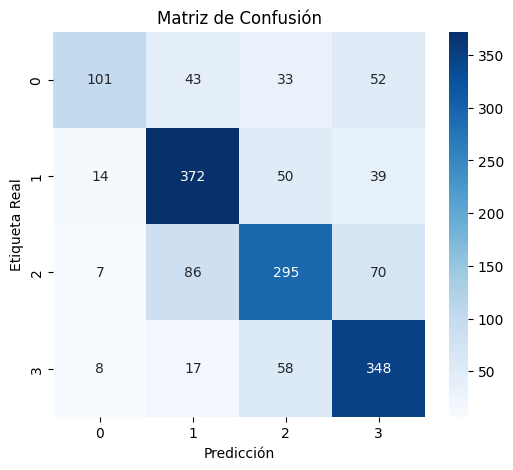

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(df_results["Label"], df_results["Prediction"])

# Crear el heatmap con la matriz de confusión
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=set(df_results["Label"]), yticklabels=set(df_results["Label"]))
plt.xlabel("Predicción")
plt.ylabel("Etiqueta Real")
plt.title("Matriz de Confusión")
plt.show()


Testing ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100/100 0:00:11 • 0:00:00 8.64it/s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.30069053173065186    │
└───────────────────────────┴───────────────────────────┘

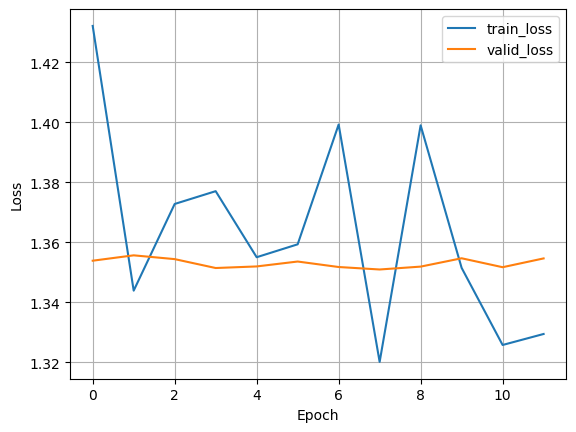

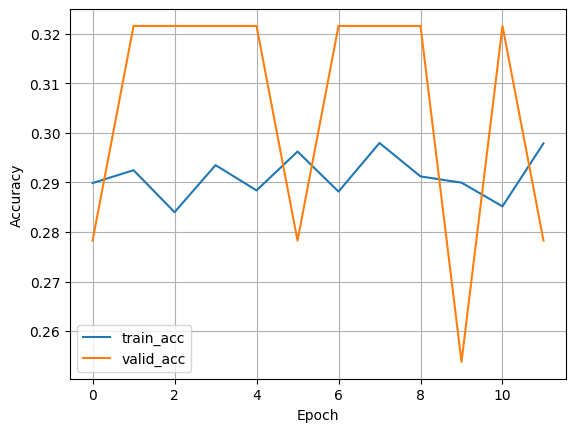

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


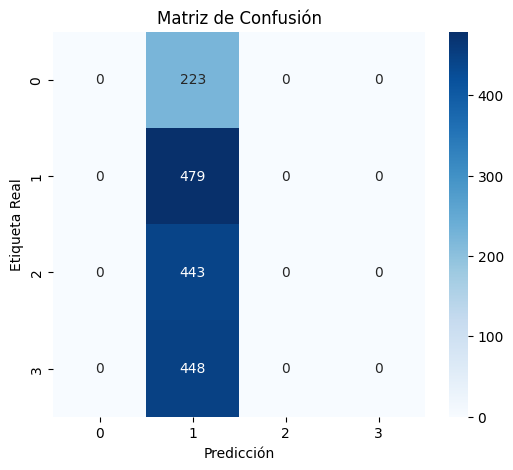

In [ ]:
import kagglehub
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import TQDMProgressBar, RichProgressBar
import torchmetrics
from torchvision import datasets
from torch.utils.data import DataLoader, random_split

# Descargar el dataset desde Kaggle
path = kagglehub.dataset_download("devzohaib/dog-emotions-prediction")
print("Path to dataset files:", path)

# Ruta ajustada al directorio de las imágenes
dataset_path = os.path.join(path, "images")

# Verificar que la ruta existe
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"No se encontró la ruta: {dataset_path}")

# Hiperparámetros
BATCH_SIZE = 16
NUM_EPOCHS = 60
LEARNING_RATE = 0.001
NUM_WORKERS = 4
NUM_CLASSES = 4  # Ajustar según el número de clases en el dataset

# DataModule para cargar y preprocesar los datos
class DogEmotionsDataModule(pl.LightningDataModule):
    def __init__(self, data_path="./"):
        super().__init__()
        self.data_path = data_path

    def prepare_data(self):
        self.train_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.RandomRotation(degrees=15),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        self.test_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    def setup(self, stage=None):
        dataset = datasets.ImageFolder(
            root=self.data_path,
            transform=self.train_transform if stage == 'fit' else self.test_transform
        )

        train_size = int(0.8 * len(dataset))
        val_size = int(0.1 * len(dataset))
        test_size = len(dataset) - train_size - val_size

        self.train, self.valid, self.test = random_split(dataset, [train_size, val_size, test_size])

    def train_dataloader(self):
        return DataLoader(self.train, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

    def val_dataloader(self):
        return DataLoader(self.valid, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

    def test_dataloader(self):
        return DataLoader(self.test, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# Inicialización del DataModule
data_path = "/root/.cache/kagglehub/datasets/devzohaib/dog-emotions-prediction/versions/1/images"
data_module = DogEmotionsDataModule(data_path=data_path)
data_module.prepare_data()
data_module.setup(stage='fit')

# Cargar VGG16 con pesos preentrenados
pytorch_model = torchvision.models.vgg16(weights='VGG16_Weights.IMAGENET1K_V1')

# Modificar la capa clasificadora de VGG16
pytorch_model.classifier[6] = nn.Linear(
    in_features=4096,  # Salida de la última capa lineal de VGG16
    out_features=NUM_CLASSES  # Número de clases en la salida
)

# Congelar las primeras capas de VGG16
threshold = 20  # Ajustar según sea necesario
for i, param in enumerate(pytorch_model.parameters()):
    if i < threshold:
        param.requires_grad = False
    else:
        param.requires_grad = True

# Clase Lightning para el modelo
class Lightning_CNN(pl.LightningModule):
    def __init__(self, model, learning_rate, classes):
        super().__init__()
        self.learning_rate = learning_rate
        self.model = model
        self.classes = classes
        self.save_hyperparameters(ignore=["model"])
        self.train_acc = torchmetrics.Accuracy(num_classes=classes, task='multiclass')
        self.valid_acc = torchmetrics.Accuracy(num_classes=classes, task='multiclass')
        self.test_acc = torchmetrics.Accuracy(num_classes=classes, task='multiclass')

    def forward(self, x):
        return self.model(x)

    def _shared_step(self, batch):
        features, true_labels = batch
        logits = self(features)
        loss = F.cross_entropy(logits, true_labels)
        probs = F.softmax(logits, dim=1)
        predicted_labels = torch.argmax(probs, dim=1)
        return loss, true_labels, predicted_labels

    def training_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.log("train_loss", loss)
        self.model.eval()
        with torch.no_grad():
            _, true_labels, predicted_labels = self._shared_step(batch)
        self.train_acc(predicted_labels, true_labels)
        self.log("train_acc", self.train_acc, on_epoch=True, on_step=False)
        self.model.train()
        return loss

    def validation_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.log("valid_loss", loss)
        self.valid_acc(predicted_labels, true_labels)
        self.log("valid_acc", self.valid_acc, on_epoch=True, on_step=False, prog_bar=True)

    def test_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.test_acc(predicted_labels, true_labels)
        self.log("test_acc", self.test_acc, on_epoch=True, on_step=False)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

# Inicialización del modelo Lightning
lightning_model = Lightning_CNN(pytorch_model, learning_rate=LEARNING_RATE, classes=NUM_CLASSES)

# Callbacks y entrenamiento
callback_check = ModelCheckpoint(save_top_k=1, mode="max", monitor="valid_acc")
callback_tqdm = RichProgressBar(leave=True)
early_stop_callback = EarlyStopping(monitor="valid_acc", patience=10, mode="max")
logger = CSVLogger(save_dir="./logs/", name="dog-emotion")

trainer = pl.Trainer(
    max_epochs=NUM_EPOCHS,
    callbacks=[callback_check, callback_tqdm, early_stop_callback],
    accelerator="auto",
    devices="auto",
    logger=logger,
    log_every_n_steps=100
)

# Entrenamiento
start_time = time.time()
trainer.fit(model=lightning_model, datamodule=data_module)
runtime = (time.time() - start_time) / 60
print(f"Tiempo de entrenamiento en minutos: {runtime:.2f}")

# Prueba del modelo
trainer.test(model=lightning_model, datamodule=data_module, ckpt_path='best')

# Visualización de resultados
metrics_path = f"{trainer.logger.log_dir}/metrics.csv"
metrics = pd.read_csv(metrics_path)

aggreg_metrics = []
for i, dfg in metrics.groupby("epoch"):
    agg = dict(dfg.mean())
    agg["epoch"] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[["train_loss", "valid_loss"]].plot(grid=True, legend=True, xlabel="Epoch", ylabel="Loss")
df_metrics[["train_acc", "valid_acc"]].plot(grid=True, legend=True, xlabel="Epoch", ylabel="Accuracy")
plt.show()

# Matriz de confusión
test_dataloader = data_module.test_dataloader()
predictions = []
labels = []

lightning_model.eval()
with torch.no_grad():
    for batch in test_dataloader:
        inputs, targets = batch
        outputs = lightning_model(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        labels.extend(targets.cpu().numpy())

df_results = pd.DataFrame({"Label": labels, "Prediction": predictions})
conf_matrix = confusion_matrix(df_results["Label"], df_results["Prediction"])

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=set(df_results["Label"]), yticklabels=set(df_results["Label"]))
plt.xlabel("Predicción")
plt.ylabel("Etiqueta Real")
plt.title("Matriz de Confusión")
plt.show()

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.11.0
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 127MB/s] 
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at ./logs/dog-emotion/version_2/checkpoints/epoch=1-step=796.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at ./logs/dog-emotion/version_2/checkpoints/epoch=1-step=796.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.521029531955719     │
└───────────────────────────┴───────────────────────────┘

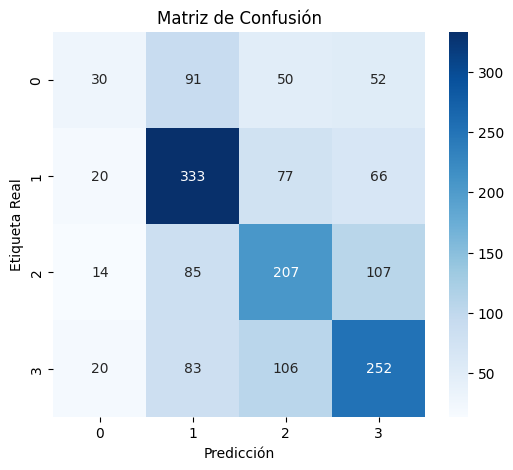

In [ ]:
import kagglehub
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import pandas as pd

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
import torchmetrics
from torchvision import datasets
from torch.utils.data import DataLoader, random_split
from pytorch_lightning.loggers import CSVLogger

# Descargar dataset
path = kagglehub.dataset_download("devzohaib/dog-emotions-prediction")
dataset_path = os.path.join(path, "images")

# Transformaciones optimizadas para mejorar generalización
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Cargar dataset
dataset = datasets.ImageFolder(root=dataset_path, transform=transform_train)
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

BATCH_SIZE = 32
NUM_WORKERS = 4

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)

# Modelo preentrenado: EfficientNet-B0 para mejor rendimiento en imágenes pequeñas
pytorch_model = torch.hub.load('pytorch/vision:v0.11.0', 'efficientnet_b0', weights='EfficientNet_B0_Weights.IMAGENET1K_V1')

# Congelar capas excepto las últimas para mejorar eficiencia
for param in pytorch_model.features.parameters():
    param.requires_grad = False

# Reemplazar la capa de clasificación final
pytorch_model.classifier[1] = nn.Linear(in_features=1280, out_features=4)

# Modelo en PyTorch Lightning
class DogEmotionClassifier(pl.LightningModule):
    def __init__(self, model, lr, num_classes):
        super().__init__()
        self.model = model
        self.lr = lr
        self.num_classes = num_classes

        # Métricas
        self.train_acc = torchmetrics.Accuracy(task='multiclass', num_classes=self.num_classes)
        self.val_acc = torchmetrics.Accuracy(task='multiclass', num_classes=self.num_classes)
        self.test_acc = torchmetrics.Accuracy(task='multiclass', num_classes=self.num_classes)

    def forward(self, x):
        return self.model(x)

    def _shared_step(self, batch):
        images, labels = batch
        logits = self(images)
        loss = nn.CrossEntropyLoss()(logits, labels)
        preds = torch.argmax(logits, dim=1)
        return loss, labels, preds

    def training_step(self, batch, batch_idx):
        loss, labels, preds = self._shared_step(batch)
        self.train_acc(preds, labels)
        self.log("train_loss", loss, on_epoch=True)
        self.log("train_acc", self.train_acc, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, labels, preds = self._shared_step(batch)
        self.val_acc(preds, labels)
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        self.log("val_acc", self.val_acc, on_epoch=True, prog_bar=True)

    def test_step(self, batch, batch_idx):
        loss, labels, preds = self._shared_step(batch)
        self.test_acc(preds, labels)
        self.log("test_acc", self.test_acc, on_epoch=True)

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.lr)

# Parámetros de entrenamiento
LEARNING_RATE = 0.0005
EPOCHS = 50

# Inicializar modelo
model = DogEmotionClassifier(pytorch_model, lr=LEARNING_RATE, num_classes=4)

# Callbacks
checkpoint_callback = ModelCheckpoint(monitor="val_acc", mode="max", save_top_k=1)
early_stop_callback = EarlyStopping(monitor="val_acc", patience=5, mode="max")

# Logger
logger = CSVLogger(save_dir="./logs", name="dog-emotion")

# Entrenador
trainer = pl.Trainer(
    max_epochs=EPOCHS,
    callbacks=[checkpoint_callback, early_stop_callback],
    accelerator="auto",
    devices="auto",
    logger=logger
)

# Entrenamiento
trainer.fit(model, train_loader, val_loader)

# Evaluación en test set
trainer.test(model, dataloaders=test_loader, ckpt_path="best")

# Obtener predicciones
all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Guardar predicciones en DataFrame
df_results = pd.DataFrame({"Label": all_labels, "Prediction": all_preds})

# Graficar matriz de confusión
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(df_results["Label"], df_results["Prediction"])

plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=set(df_results["Label"]), yticklabels=set(df_results["Label"]))
plt.xlabel("Predicción")
plt.ylabel("Etiqueta Real")
plt.title("Matriz de Confusión")
plt.show()


In [ ]:
df_results.count()

,0
Label,1593
Prediction,1593


In [ ]:
trainer.test(model, dataloaders=test_loader, ckpt_path="best")

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at ./logs/dog-emotion/version_2/checkpoints/epoch=1-step=796.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at ./logs/dog-emotion/version_2/checkpoints/epoch=1-step=796.ckpt
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5247960090637207     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.5247960090637207}]

In [ ]:
from datetime import datetime

# Obtener la fecha y hora actual
now = datetime.now()

# Formato estándar: YYYY-MM-DD HH:MM:SS
print("Fecha y Hora:", now.strftime("%Y-%m-%d %H:%M:%S"))

# Formato detallado con zona horaria UTC
print("Fecha y Hora UTC:", now.strftime("%Y-%m-%d %H:%M:%S %Z"))

# Formato con día de la semana
print("Fecha y Hora Completa:", now.strftime("%A, %d de %B de %Y, %H:%M:%S"))

# Formato compacto para logs
print("Log Timestamp:", now.strftime("%Y%m%d_%H%M%S"))


Fecha y Hora: 2025-02-06 15:35:53
Fecha y Hora UTC: 2025-02-06 15:35:53 
Fecha y Hora Completa: Thursday, 06 de February de 2025, 15:35:53
Log Timestamp: 20250206_153553


In [ ]:
import kagglehub
import numpy as np
import os
%matplotlib inline
import matplotlib.pyplot as plt
import time
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
import torchmetrics

from collections import Counter
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split

from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import TQDMProgressBar, RichProgressBar

# Download latest version
path = kagglehub.dataset_download("devzohaib/dog-emotions-prediction")

print("Path to dataset files:", path)

import os
import kagglehub
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Descargar el dataset desde Kaggle
path = kagglehub.dataset_download("devzohaib/dog-emotions-prediction")
print("Path to dataset files:", path)

# Ruta ajustada al directorio de las imágenes
dataset_path = os.path.join(path, "images")

# Transformaciones para las imágenes
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Redimensionar imágenes a 128x128 píxeles
    transforms.ToTensor(),         # Convertir imágenes a tensores
    transforms.Normalize((0.5,), (0.5,))  # Normalizar valores de píxeles
])

# Verificar que la ruta existe
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"No se encontró la ruta: {dataset_path}")

# Cargar el dataset usando ImageFolder
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Dividir en dataset de entrenamiento y prueba
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Crear DataLoaders
BATCH_SIZE = 32
NUM_WORKERS = 2

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         num_workers=NUM_WORKERS,
                         shuffle=False)

# Visualización de imágenes de entrenamiento
for images, labels in train_loader:
    break

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Imágenes de entrenamiento")
plt.imshow(np.transpose(torchvision.utils.make_grid(
    images[:64],
    padding=2,
    normalize=True),
    (1, 2, 0)))
plt.show()

print("Dimensión de entrada:", images.shape)  # (batch_size, channels, W, H)
print("Etiquetas:", [dataset.classes[label] for label in labels[:10]])


BATCH_SIZE = 16
NUM_EPOCHS = 60
LEARNING_RATE = 0.001
NUM_WORKERS = 4 # unidades de procesamiento o hilos
CLASES = 10


import os
import pytorch_lightning as pl
from torchvision import transforms, datasets
from torch.utils.data import random_split, DataLoader


class DogEmotionsDataModule(pl.LightningDataModule):
    def __init__(self, data_path="./"):
        super().__init__()
        self.data_path = data_path  # Ruta donde está el dataset

    def prepare_data(self):
        # Transformaciones para entrenamiento
        self.train_transform = transforms.Compose([
            transforms.Resize((224, 224)),  # Redimensionar imágenes para RESNET18
            transforms.RandomHorizontalFlip(p=0.5),  # Volteo horizontal con probabilidad 50%
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Ajustes aleatorios de color
            transforms.RandomRotation(degrees=15),  # Rotación aleatoria entre -15 y 15 grados
            transforms.ToTensor(),  # Convertir imagen en tensor
            transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalización basada en ImageNet
                                 std=[0.229, 0.224, 0.225]),
        ])

        # Transformaciones para prueba y validación
        self.test_transform = transforms.Compose([
            transforms.Resize((224, 224)),  # Redimensionar imágenes
            transforms.ToTensor(),  # Convertir imagen en tensor
            transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalización basada en ImageNet
                                 std=[0.229, 0.224, 0.225]),
        ])
        return

    def setup(self, stage=None):
        # Cargar dataset usando ImageFolder
        dataset = datasets.ImageFolder(
            root=self.data_path,
            transform=self.train_transform if stage == 'fit' else self.test_transform
        )

        # Dividir dataset en entrenamiento (80%), validación (10%) y prueba (10%)
        train_size = int(0.8 * len(dataset))
        val_size = int(0.1 * len(dataset))
        test_size = len(dataset) - train_size - val_size

        self.train, self.valid, self.test = random_split(dataset, [train_size, val_size, test_size])

        print("Muestras de entrenamiento:", len(self.train))
        print("Muestras de validación:", len(self.valid))
        print("Muestras de evaluación:", len(self.test))

    def train_dataloader(self):
        train_loader = DataLoader(
            dataset=self.train,
            batch_size=BATCH_SIZE,
            drop_last=True,
            shuffle=True,
            num_workers=NUM_WORKERS,
        )
        return train_loader

    def val_dataloader(self):
        valid_loader = DataLoader(
            dataset=self.valid,
            batch_size=BATCH_SIZE,
            drop_last=False,
            shuffle=False,
            num_workers=NUM_WORKERS,
        )
        return valid_loader

    def test_dataloader(self):
        test_loader = DataLoader(
            dataset=self.test,
            batch_size=BATCH_SIZE,
            drop_last=False,
            shuffle=False,
            num_workers=NUM_WORKERS,
        )
        return test_loader



data_path = "/root/.cache/kagglehub/datasets/devzohaib/dog-emotions-prediction/versions/1/images"

data_module = DogEmotionsDataModule(data_path=data_path)
data_module.prepare_data()
data_module.setup(stage='fit')

train_loader = data_module.train_dataloader()
valid_loader = data_module.val_dataloader()
test_loader = data_module.test_dataloader()


# Inicialización de DataModule
torch.manual_seed(47)  # Fijar una semilla para reproducibilidad

# Especifica la ruta correcta al dataset de imágenes de emociones de perros
data_path = "/root/.cache/kagglehub/datasets/devzohaib/dog-emotions-prediction/versions/1/images"

# Inicializar el DataModule con la nueva clase
data_module = DogEmotionsDataModule(data_path=data_path)

# Preparar los datos (transformaciones y verificaciones)
data_module.prepare_data()

# Configurar el dataset para entrenamiento, validación y prueba
data_module.setup(stage='fit')


pytorch_model = torch.hub.load('pytorch/vision:v0.11.0', 'mobilenet_v2', weights='MobileNet_V2_Weights.IMAGENET1K_V1')

# Sobre escribimos el clasificador de la red, el cual es la ultima capa [-1]
pytorch_model.classifier[1] = torch.nn.Linear(
    in_features=1280,  # Salida del último bloque convolucional de MobileNetV2
    out_features=4  # Número de clases en la salida
)


#anda probando bloque por bloque
threshold = 130 # no se modifica el ~80% del número total de parámetros de RESNET18
for i, param in enumerate(pytorch_model.parameters()):
    if i < threshold:
        param.requires_grad = False
    elif i >= threshold:
        param.requires_grad = True

class Lightning_CNN(pl.LightningModule):
    def __init__(self, model, learning_rate, classes):
        super().__init__()

        self.learning_rate = learning_rate
        self.model = model
        self.classes = classes

        # Guardar hiperparametros en directorio de logs
        # Ignora los pesos del modelo
        self.save_hyperparameters(ignore=["model"])

        # Definición de métricas para cada grupo de datos
        self.train_acc = torchmetrics.Accuracy(num_classes = self.classes, task='multiclass')
        self.valid_acc = torchmetrics.Accuracy(num_classes = self.classes, task='multiclass')
        self.test_acc = torchmetrics.Accuracy(num_classes = self.classes, task='multiclass')

    # Defining the forward method is only necessary
    # if you want to use a Trainer's .predict() method (optional)
    def forward(self, x):
        return self.model(x)

    # Pasos del proceso forward comunes entre train, val, test
    def _shared_step(self, batch):
        features, true_labels = batch
        logits = self(features)
        loss = torch.nn.functional.cross_entropy(logits, true_labels) # cross entropy loss recibe logits y labels como entrada. No recibe probabilidades!
        probs = torch.nn.functional.softmax(logits, dim=1)
        predicted_labels = torch.argmax(probs, dim=1)

        return loss, true_labels, predicted_labels

    def training_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.log("train_loss", loss)

        # Do another forward pass in .eval() mode to compute accuracy
        # while accounting for Dropout, BatchNorm etc. behavior
        # during evaluation (inference)
        self.model.eval()
        with torch.no_grad():
            _, true_labels, predicted_labels = self._shared_step(batch)
        self.train_acc(predicted_labels, true_labels)
        self.log("train_acc", self.train_acc, on_epoch=True, on_step=False)
        self.model.train()

        return loss  # this is passed to the optimzer for training

    def validation_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.log("valid_loss", loss)
        self.valid_acc(predicted_labels, true_labels)
        self.log("valid_acc", self.valid_acc, on_epoch=True, on_step=False, prog_bar=True)

    def test_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.test_acc(predicted_labels, true_labels)
        self.log("test_acc", self.test_acc, on_epoch=True, on_step=False)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

# Inicialización del modulo lightning

lightning_model = Lightning_CNN(pytorch_model, learning_rate=LEARNING_RATE, classes=CLASES)

callback_check = ModelCheckpoint(save_top_k=1, mode="max", monitor="valid_acc") # guardamos el mejor modelo monitoreado en la acc de validación. Por qué no la de entrenamiento?

callback_tqdm = RichProgressBar(leave=True)

early_stop_callback = EarlyStopping( # se agrega un callback de earlystopping para asegurar que el modelo se detenga en un momento óptimo monitoreando la métrica de accuracy
    monitor="valid_acc",
    patience=10, # se establece una paciencia de 3 épocas
    mode="max"
)

logger = CSVLogger(save_dir="./logs/", name="dog-emotion")


#  Inicia entrenamiento

trainer = pl.Trainer(max_epochs= NUM_EPOCHS,
                    callbacks=[callback_check, callback_tqdm, early_stop_callback],
                    accelerator="auto",  # Uses GPUs or TPUs if available
                    devices="auto",  # Uses all available GPUs/TPUs if applicable
                    logger=logger,
                    log_every_n_steps=100)

start_time = time.time()
trainer.fit(model = lightning_model, datamodule = data_module)

runtime = (time.time() - start_time) / 60
print(f"Tiempo de entrenamiento en minutos: {runtime:.2f}")


import pandas as pd
import matplotlib.pyplot as plt

# Leer métricas del archivo CSV generado por el logger
metrics_path = f"{trainer.logger.log_dir}/metrics.csv"
metrics = pd.read_csv(metrics_path)

# Agregar métricas por época
aggreg_metrics = []
agg_col = "epoch"  # Agrupar por la columna de época
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())  # Calcular la media para todas las métricas por época
    agg[agg_col] = i
    aggreg_metrics.append(agg)

# Convertir a DataFrame para visualización
df_metrics = pd.DataFrame(aggreg_metrics)

# Graficar las pérdidas (loss) para entrenamiento y validación
df_metrics[["train_loss", "valid_loss"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="Loss", title="Loss vs Epoch"
)

# Graficar las precisiones (accuracy) para entrenamiento y validación
df_metrics[["train_acc", "valid_acc"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="Accuracy", title="Accuracy vs Epoch"
)

# Mostrar las gráficas
plt.show()



# Probar el modelo utilizando el mejor checkpoint guardado
trainer.test(model = lightning_model, datamodule = data_module, ckpt_path = 'best')



# Obtener el dataloader de prueba
test_dataloader = data_module.test_dataloader()

# Listas para almacenar los resultados
predictions = []
labels = []

# Modo evaluación
lightning_model.eval()

# Deshabilitar el cálculo de gradientes para inferencia
with torch.no_grad():
    for batch in test_dataloader:
        inputs, targets = batch  # Obtener imágenes y etiquetas verdaderas

        outputs = lightning_model(inputs)  # Obtener predicciones del modelo

        _, predicted = torch.max(outputs, 1)  # Obtener la clase con mayor probabilidad

        predictions.extend(predicted.cpu().numpy())  # Guardar predicciones
        labels.extend(targets.cpu().numpy())  # Guardar etiquetas reales

# Crear un DataFrame con los resultados
df_results = pd.DataFrame({"Label": labels, "Prediction": predictions})


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(df_results["Label"], df_results["Prediction"])

# Crear el heatmap con la matriz de confusión
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=set(df_results["Label"]), yticklabels=set(df_results["Label"]))
plt.xlabel("Predicción")
plt.ylabel("Etiqueta Real")
plt.title("Matriz de Confusión")
plt.show()
